In [1]:
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

$ AnnualIncome = 20000 + 1000 * Age $

education_level -> state -> county

In [2]:
set_parameters = (
    (('no degree', 'CA', 'Riverside County'), (5000, 1250)),
    (('no degree', 'IL', 'Cook County'), (6500, 1150)),
    (('no degree', 'IL', 'Lake County'), (7000, 1350)),
    
    (('degree', 'CA', 'Riverside County'), (6000, 1250)),
    (('degree', 'IL', 'Cook County'), (7500, 1150)),
    (('degree', 'IL', 'Lake County'), (8000, 1350))
)

In [5]:
data_points = np.random.randint(1,24, size=len(set_parameters))

In [6]:
rows = []
for set_parameter, N in zip(set_parameters, data_points):
  key, parameters = set_parameter
  population_rows = [{
      'degree': key[0],
      'state': key[1],
      'county': key[2],
      'month_index': i,
      'salary': i*parameters[0] + parameters[1] + np.random.normal(loc=0, scale=500)
  } for i in range(N)]
  rows += population_rows

salary_df = pd.DataFrame(rows)

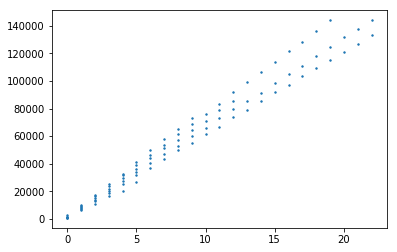

In [7]:
plt.scatter(salary_df.month_index, salary_df.salary, s=2);

In [8]:
# Index each of the unique variable values
degree_index = salary_df.groupby('degree').all().reset_index().reset_index()[['index', 'degree']]
degree_state_index = salary_df.groupby(['degree', 'state']).all().reset_index().reset_index()[['index', 'degree', 'state']]
degree_state_county_index = salary_df.groupby(['degree', 'state', 'county']).all().reset_index().reset_index()[['index', 'degree', 'state', 'county']]

degree_state_indexes_df = pd.merge(degree_index, degree_state_index, how='inner', on='degree', suffixes=('_d', '_ds'))
degree_state_county_indexes_df = pd.merge(degree_state_indexes_df, degree_state_county_index, how='inner', on=['degree', 'state'])
indexed_salary_df = pd.merge(salary_df, degree_state_county_indexes_df, how='inner', on=['degree', 'state', 'county']).reset_index()


In [ ]:
import pymc3 as pm

degree_indexes = degree_index['index'].values
degree_count = len(degree_indexes)
degree_state_indexes = degree_state_indexes_df['index_d'].values
degree_state_count = len(degree_state_indexes)
degree_state_county_indexes = degree_state_county_indexes_df['index_ds'].values
degree_state_county_count = len(degree_state_county_indexes)

with pm.Model() as model:
    global_m = pm.Normal('global_m', mu=6500, sd=100**2)
    global_m_sd = pm.Uniform('global_m_sd', lower=0, upper=1000)
    global_b = pm.Normal('global_b', mu=1000, sd=100**2)
    global_b_sd = pm.Uniform('global_b_sd', lower=0, upper=1000)
    
    degree_m = pm.Normal('degree_m', mu=global_m, sd=global_m_sd, shape=degree_count)
    degree_m_sd = pm.Uniform('degree_m_sd', lower=0, upper=1000, shape=degree_count)
    degree_b = pm.Normal('degree_b', mu=global_b, sd=global_b_sd, shape=degree_count)
    degree_b_sd = pm.Uniform('degree_b_sd', lower=0, upper=1000, shape=degree_count)
    
    degree_state_m = pm.Normal('degree_state_m', mu=degree_m[degree_state_indexes], sd=degree_m_sd[degree_state_indexes], shape=degree_state_count)
    degree_state_m_sd = pm.Uniform('degree_state_m_sd', lower=0, upper=1000, shape=degree_state_count)
    degree_state_b = pm.Normal('degree_state_b', mu=degree_b[degree_state_indexes], sd=degree_b_sd[degree_state_indexes], shape=degree_state_count)
    degree_state_b_sd = pm.Uniform('degree_state_b_sd', lower=0, upper=1000, shape=degree_state_count)
    
    degree_state_county_m = pm.Normal('degree_state_county_m', mu=degree_state_m[degree_state_county_indexes], sd=degree_state_m_sd[degree_state_county_indexes], shape=degree_state_county_count)
    degree_state_county_b = pm.Normal('degree_state_county_b', mu=degree_state_b[degree_state_county_indexes], sd=degree_state_b_sd[degree_state_county_indexes], shape=degree_state_county_count)
    
    error = pm.Uniform('error', lower=0, upper=10000)
    
    y_prediction = degree_state_county_m[indexed_salary_df['index'].values] * indexed_salary_df.month_index.values + degree_state_county_b[indexed_salary_df['index'].values]
    
    pm.StudentT('y_like', nu=1, mu=0, sd=error, observed=y_prediction - indexed_salary_df.salary.values)
    
    model_trace = pm.sample(5000)

INFO (theano.gof.compilelock): Refreshing lock /Users/justin/.theano/compiledir_Darwin-16.5.0-x86_64-i386-64bit-i386-3.4.4-64/lock_dir/lock


In [ ]:
pm.traceplot(model_trace[1000:]);

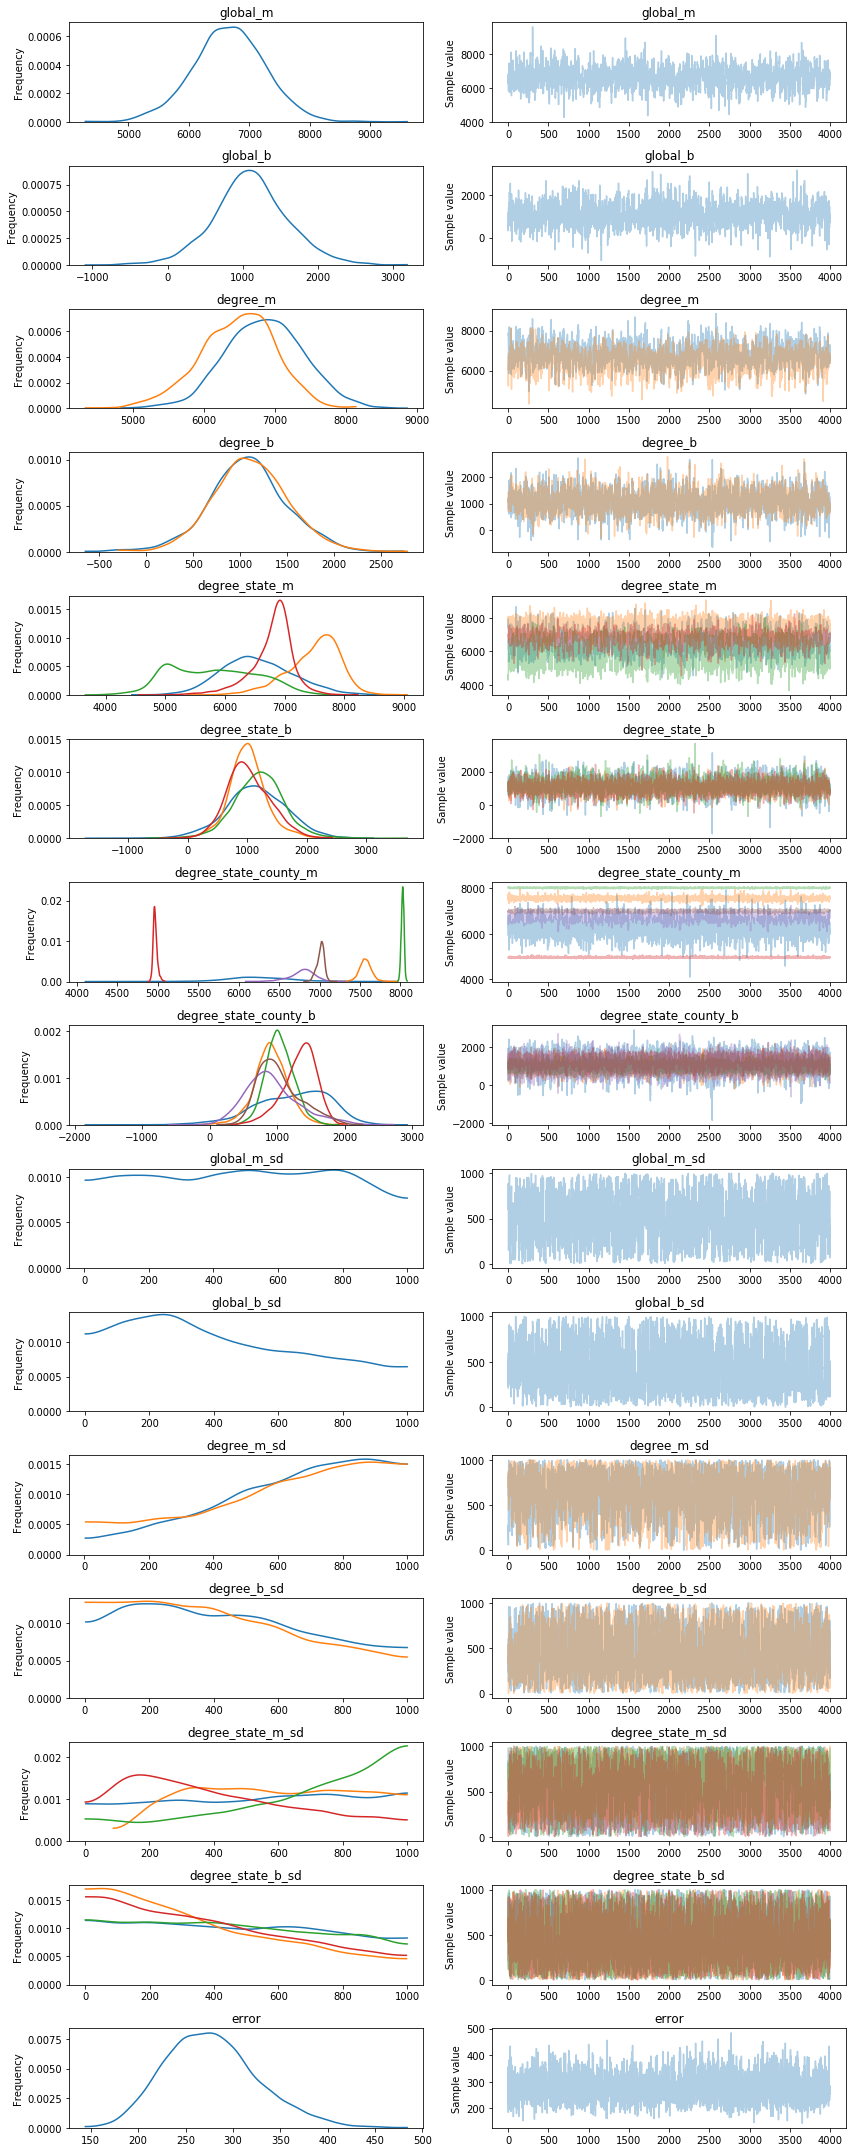

In [184]:
%matplotlib inline

pm.traceplot(model_trace[1000:]);

In [183]:
pm.summary(model_trace)


global_m:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  6637.890         657.386          22.021           [5447.803, 7831.476]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  5412.829       6270.124       6659.213       7036.623       7809.716


global_b:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1100.806         516.587          12.610           [95.963, 2146.075]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  81.232         791.504        1093.225       1416.669       2137.425


degree_m:

  Mean             SD               MC Error         95% HPD interval
  

$$ Y = m X + b  \\$$
